In [1]:
import torch
from BallDetSystem import BallDetSystem
from utils.models import BallLocateModel

ball_sys = BallDetSystem()

model = BallLocateModel()

# 加载模型权重
path = "logs/resnet/model_weights_resnet18_v3_2.pth"
model.load_state_dict(torch.load(path,map_location=torch.device('cpu'),))


/Users/chyou/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chyou/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

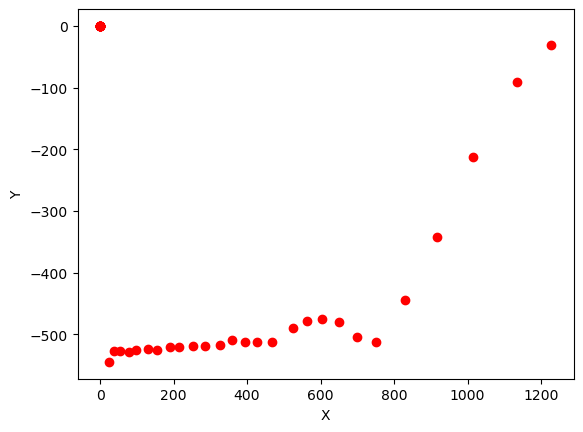

In [2]:
video_path = "img/1.mp4"
track_saved_path = "img/nps/1.npy"

centers = ball_sys.detect_video(video_path,track_saved_path)

ball_sys.plot_points(centers)




In [3]:
key_frame_ind,key_frame_cor = ball_sys.find_opt_frame(centers)
print(key_frame_ind)
print(key_frame_cor)




9
[752 512]


<class 'numpy.ndarray'>


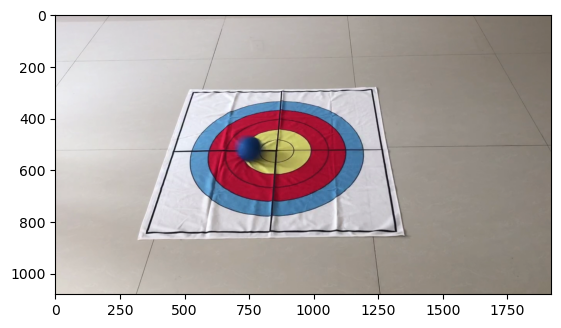

In [4]:
import matplotlib.pyplot as plt

key_frame = ball_sys.get_frame_from_video(video_path,key_frame_ind)
print(type(key_frame))
plt.imshow(key_frame)

In [6]:
from PIL import Image
# 获取yolo模型预测的帧数
# 将 NumPy 数组转换为 PIL 图像对象
pil_image = Image.fromarray(key_frame)
tac_time = ball_sys.get_FPS(image=pil_image,det_interval=120)

60/tac_time

1915.7369036759974

In [5]:
import cv2

# 读取图像
key_frame = cv2.imread('img/IMG_0014.JPG')

# 如果需要，将图像从 BGR 格式转换为 RGB 格式
key_frame = cv2.cvtColor(key_frame, cv2.COLOR_BGR2RGB)

# 现在，变量 image 就是一个 NumPy 数组，您可以对其进行任何 NumPy 数组的操作


In [42]:
import torchvision.transforms as transforms

# 对图像进行预处理
trans = transforms.Compose([
    transforms.ToTensor(),  # 转换为 Tensor
    transforms.Resize((216, 384)),  # 调整大小
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 执行预处理
img_tensor = trans(key_frame)

# 添加批次维度（batch dimension）
image_tensor = img_tensor.unsqueeze(0)

# 选择设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device:" + str(device))
print(type(device))

device:cpu
<class 'torch.device'>


/Users/chyou/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


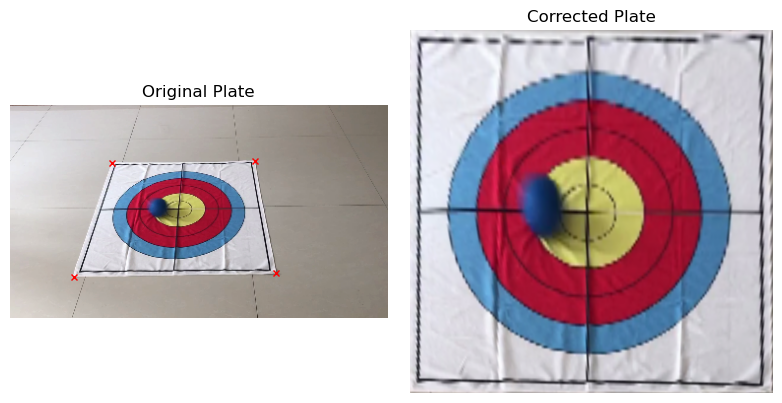

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# 假设你已经有了image_tensor和model
# 获取模型输出
with torch.no_grad():
    model.eval()
    image_tensor = image_tensor.to("cpu")
    output = model(image_tensor)

predicted_coords = output.squeeze().detach().cpu().numpy()
image = img_tensor.numpy()
normalized_image = (image * np.array([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]) + np.array([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis]
normalized_image = np.clip(normalized_image, 0, 1)
normalized_image = (normalized_image * 255).astype(np.uint8)
image = normalized_image.transpose(1, 2, 0)  

# 定义源和目标点坐标
source_points = np.array([[predicted_coords[0], predicted_coords[1]],
                          [predicted_coords[2], predicted_coords[3]],
                          [predicted_coords[4], predicted_coords[5]],
                          [predicted_coords[6], predicted_coords[7]]], dtype=np.float32)
plate_width = 800
plate_height = 800
target_points = np.array([[0, 0], [plate_width - 1, 0], [0, plate_height - 1], [plate_width - 1, plate_height - 1]], dtype=np.float32)

# 计算透视变换矩阵
M = cv2.getPerspectiveTransform(source_points, target_points)

# 进行透视变换
corrected_plate = cv2.warpPerspective(image, M, (plate_width, plate_height))

# 绘制原始图像和修正后的图像以及关键点
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# 绘制原始图像
axs[0].imshow(image)
axs[0].set_title('Original Plate')
axs[0].axis('off')

# 绘制修正后的图像
axs[1].imshow(corrected_plate)
axs[1].set_title('Corrected Plate')
axs[1].axis('off')

# 绘制关键点
for point in source_points:
    axs[0].plot(point[0], point[1], marker='x', color='red', markersize=5)

plt.tight_layout()
plt.show()


## 将分割后的图片保存为jpg格式

In [219]:
from PIL import Image
import numpy as np

# 假设image_np是一个numpy数组形式的图片
# image_np = ...
print(type(corrected_plate))
# 创建PIL图像对象
image_pil = Image.fromarray(np.uint8(corrected_plate))

# 保存为jpg图片
image_pil.save('corrected_images/16_orig.jpg')

<class 'numpy.ndarray'>


<class 'numpy.ndarray'>


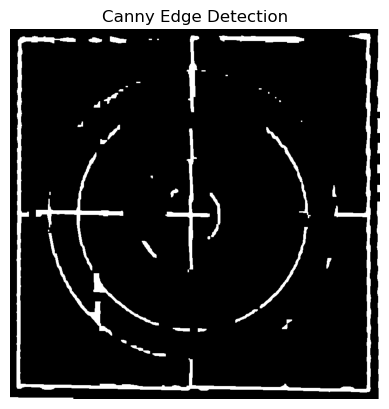

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像
#image = cv2.imread('your_image.jpg', cv2.IMREAD_GRAYSCALE)
image = corrected_plate.copy()

# 对图像进行高斯滤波来降噪
image = cv2.GaussianBlur(image, (7, 7), 0)

# 边缘检测
edges = cv2.Canny(image, threshold1=30, threshold2=135)

# 定义形态学核
kernel = np.ones((11, 11), np.uint8)

# 执行闭运算操作
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# 定义形态学核
kernel = np.ones((3, 3), np.uint8)
# 执行开运算操作
edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)

print(type(edges))
# 使用Matplotlib显示边缘图像
plt.imshow(edges, cmap='gray')  # 使用灰度色彩映射 (cmap='gray') 显示灰度图像
plt.title('Canny Edge Detection')
plt.axis('off')  # 不显示坐标轴
plt.show()


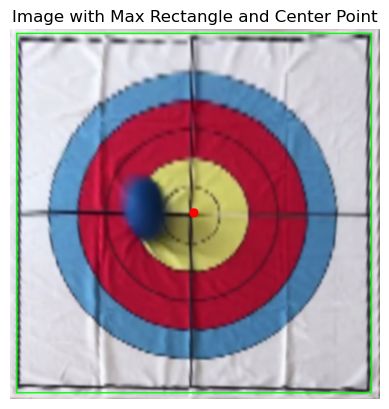

In [46]:
import cv2
import matplotlib.pyplot as plt


# 寻找图像中的轮廓
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 初始化最大矩形相关变量
max_area = 0
max_rect = None

# 遍历轮廓
for contour in contours:
    # 计算轮廓的面积
    area = cv2.contourArea(contour)
    
    # 如果面积足够大，则考虑它作为候选矩形
    if area > 1000:  # 根据需要调整阈值
        # 计算轮廓的边界矩形
        x, y, w, h = cv2.boundingRect(contour)
        
        # 如果当前矩形的面积更大，则更新最大矩形
        if area > max_area:
            max_area = area
            max_rect = (x, y, w, h)

# 在图像上绘制最大矩形和中心点
if max_rect is not None:
    x, y, w, h = max_rect
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # 计算矩形的中心点坐标
    center_x = x + w // 2
    center_y = y + h // 2
    
    # 绘制中心点
    cv2.circle(image, (center_x, center_y), 10, (255, 0, 0), -1)

# 使用Matplotlib显示图像以及最大矩形和中心点
plt.imshow(image)
plt.title('Image with Max Rectangle and Center Point')
plt.axis('off')
plt.show()

center_image = image.copy()


<class 'numpy.ndarray'>


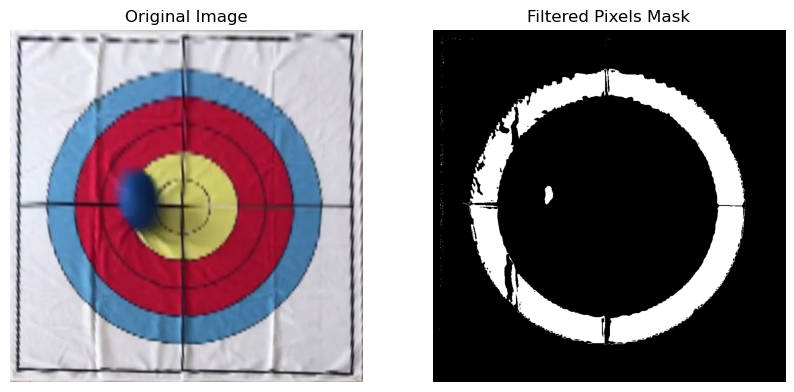

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像
#image = cv2.imread('corrected_images/16_orig.jpg')
image_rgb = corrected_plate
# 将图像从 BGR 格式转换为 RGB 格式
#image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(type(image_rgb))
# 定义RGB范围
lower_rgb = np.array([40, 80, 110])  # 最小阈值
upper_rgb = np.array([100, 160, 220])  # 最大阈值

# 创建掩码
mask = cv2.inRange(image_rgb, lower_rgb, upper_rgb)

# 将掩码可视化
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Filtered Pixels Mask')
plt.axis('off')

plt.show()


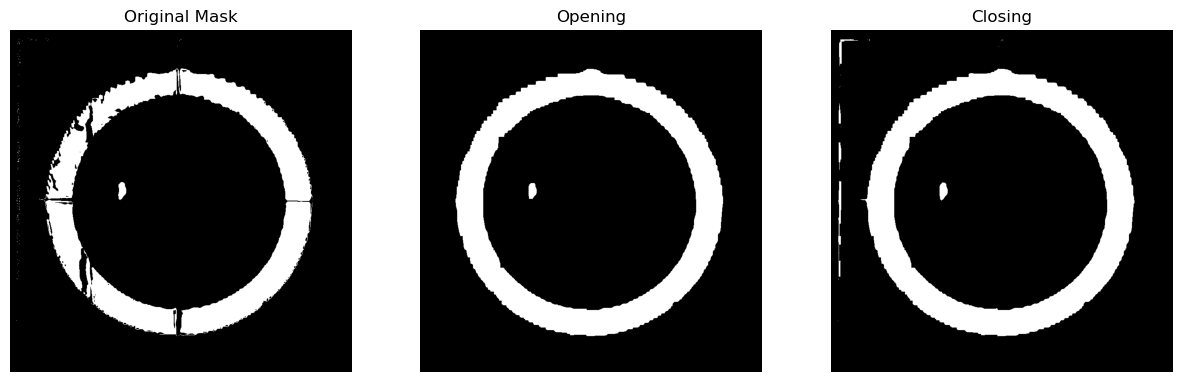

In [48]:
# 定义形态学操作的内核大小
kernel_size_closing = 24
kernel_size_opening = 9
# 定义形态学操作的内核
kernel_closing = np.ones((kernel_size_closing, kernel_size_closing), np.uint8)

kernel_opening = np.ones((kernel_size_opening, kernel_size_opening), np.uint8)

# 使用闭运算消除噪声
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_closing)

# 使用开运算消除噪声
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel_opening)

# 可视化开运算和闭运算的结果
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(opening, cmap='gray')
plt.title('Opening')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(closing, cmap='gray')
plt.title('Closing')
plt.axis('off')

plt.show()


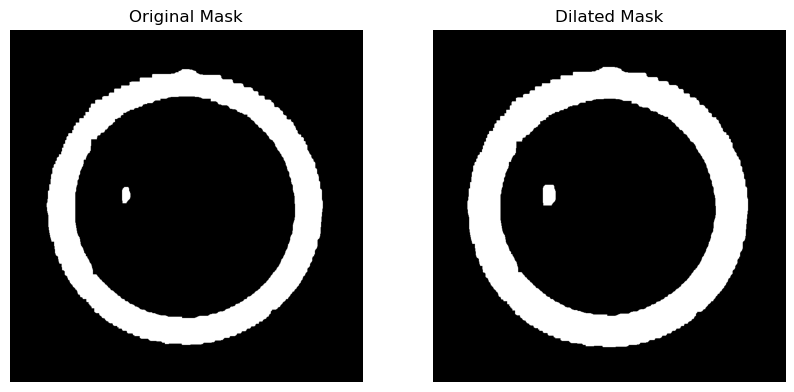

In [20]:
# 定义膨胀操作的内核大小
kernel_size = 11

# 定义膨胀操作的内核
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# 对掩码进行膨胀操作
dilated_mask = cv2.dilate(opening, kernel, iterations=1)

# 可视化结果
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(opening, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dilated_mask, cmap='gray')
plt.title('Dilated Mask')
plt.axis('off')

plt.show()


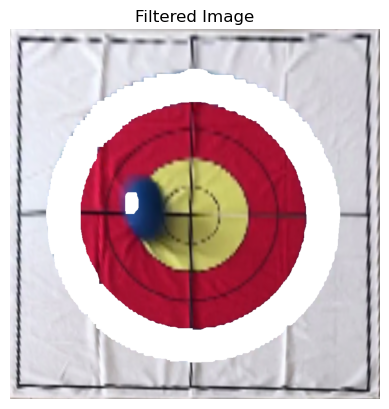

In [49]:
# 将原图转换为RGB格式（确保原图和掩码具有相同的颜色通道）
#image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

filtered_image = corrected_plate.copy()
# 将掩码取反，即将过滤出来的区域设置为0，其余区域设置为255
filtered_area = cv2.bitwise_not(dilated_mask)

# 将原图中需要过滤的像素设置为浅红色
filtered_image[filtered_area == 0] = [255, 255, 255]  # 设置为浅红色

# 可视化结果
plt.imshow(filtered_image)
plt.title('Filtered Image')
plt.axis('off')
plt.show()


## 保存进行颜色过滤后的图片

In [22]:
from PIL import Image
import numpy as np

# 假设image_np是一个numpy数组形式的图片
# image_np = ...

# 创建PIL图像对象
image_pil = Image.fromarray(np.uint8(image_rgb))

# 保存为jpg图片
image_pil.save('filtered_images/16.jpg')

(292.5166320800781, 390.2758483886719)


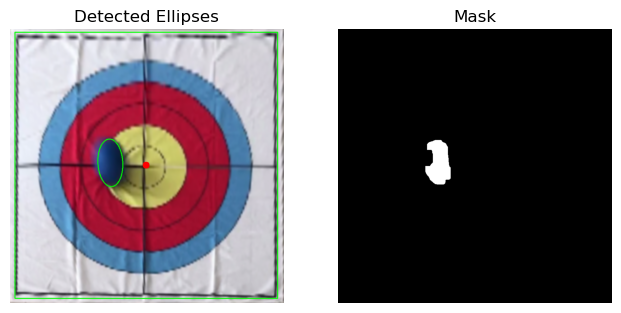

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 加载图片

#image = cv2.imread("corrected_images/1.jpg")
image = filtered_image
# 将图像转换为HSV颜色空间
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# 定义蓝色范围
lower_blue = np.array([90, 50, 50])
upper_blue = np.array([140, 255, 255])

# 根据蓝色范围进行阈值化
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# 对阈值图像进行形态学处理
kernel = np.ones((17, 17), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# 对阈值图像进行形态学处理
kernel = np.ones((21, 21), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# 使用椭圆拟合功能
contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 初始化最大面积和对应的椭圆
max_area = 0
max_ellipse = None

# 遍历所有检测到的椭圆
for contour in contours:
    # 拟合椭圆
    ellipse = cv2.fitEllipse(contour)
    # 计算椭圆的面积
    area = np.pi * ellipse[1][0] * ellipse[1][1] / 4
    # 如果当前椭圆的面积大于之前记录的最大面积，则更新最大面积和椭圆
    if area > max_area:
        max_area = area
        max_ellipse = ellipse

# 绘制最大椭圆
if max_ellipse is not None:
    cv2.ellipse(center_image, max_ellipse, (0, 255, 0), 2)
    print(max_ellipse[0])
    

# 使用Matplotlib显示结果
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(center_image)
plt.title('Detected Ellipses')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()

